# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql.types import DateType, IntegerType
from datetime import datetime

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")\
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/09/17 10:47:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/09/17 10:47:04 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json("data/mini_sparkify_event_data.json")
df.persist()

In [4]:
df.agg(countDistinct("userId").alias('count')).show()

+-----+
|count|
+-----+
|  226|
+-----+



In [5]:
print((df.count(), len(df.columns)))

(286500, 18)


In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
null_counts = df.agg(*[sum(when(col(c).isNull(), 1)).alias(c) for c in df.columns]).collect()[0].asDict()
null_counts

{'artist': 58392,
 'auth': None,
 'firstName': 8346,
 'gender': 8346,
 'itemInSession': None,
 'lastName': 8346,
 'length': 58392,
 'level': None,
 'location': 8346,
 'method': None,
 'page': None,
 'registration': 8346,
 'sessionId': None,
 'song': 58392,
 'status': None,
 'ts': None,
 'userAgent': 8346,
 'userId': None}

In [8]:
#checking if we have columns with empty values

empty_counts = df.agg(*[sum(when(col(c) == '', 1)).alias(c) for c in df.columns]).collect()[0].asDict()
empty_counts

{'artist': None,
 'auth': None,
 'firstName': None,
 'gender': None,
 'itemInSession': None,
 'lastName': None,
 'length': None,
 'level': None,
 'location': None,
 'method': None,
 'page': None,
 'registration': None,
 'sessionId': None,
 'song': None,
 'status': None,
 'ts': None,
 'userAgent': None,
 'userId': 8346}

In [9]:
#If we are predicting churns, we need the user identification, so i'm dropping all rows with empty userId
df = df.filter(col("userId") != '')

In [10]:
empty_counts = df.agg(*[sum(when(col(c) == '', 1)).alias(c) for c in df.columns]).collect()[0].asDict()
empty_counts

{'artist': None,
 'auth': None,
 'firstName': None,
 'gender': None,
 'itemInSession': None,
 'lastName': None,
 'length': None,
 'level': None,
 'location': None,
 'method': None,
 'page': None,
 'registration': None,
 'sessionId': None,
 'song': None,
 'status': None,
 'ts': None,
 'userAgent': None,
 'userId': None}

In [11]:
df = df.withColumn(
    "registration_date", from_unixtime(col("registration") / 1000, "yyyy-MM-dd")
).withColumn(
    "days_of_membership",
    ((col("ts") - col("registration")) / (1000 * 60 * 60 * 24)).cast(IntegerType())
)

The `registration_date` field represents the date when the user registered. It is formatted as 'yyyy-MM-dd', providing an ea
sy-to-understand visualization of the date.

The `days_of_membership` field in each record is a numerical variable that represents the number of days that have elapsed since the user registered for the service.

In [12]:
df.selectExpr("min(registration_date)", "max(registration_date)").show()

+----------------------+----------------------+
|min(registration_date)|max(registration_date)|
+----------------------+----------------------+
|            2018-03-18|            2018-11-26|
+----------------------+----------------------+



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [15]:
w = (
    Window.partitionBy("userId")
    .orderBy(desc("ts"))
    .rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
)

window_next_level = Window.partitionBy("userId").orderBy("ts")
df = df.withColumn("next_level", lead("level").over(window_next_level))

df = (
    df.withColumn(
        "churn_event",
        when(
            (col("page") == "Cancellation Confirmation")
            | ((col("page") == "Submit Downgrade") & (col("next_level") == "free")),
            1,
        ).otherwise(0),
    )
    .withColumn(
        "days_to_churn",
        when(
            (col("churn_event") == 1),
            ((col("ts") - col("registration")) / (1000 * 60 * 60 * 24)).cast(
                IntegerType()
            ),
        ).otherwise(None),
    )
    .withColumn("churn", max("churn_event").over(w))
    .drop("next_level")
)

In [116]:
df_pandas = df.toPandas()

In [16]:
days_to_churn = df.select("days_to_churn").filter(col("days_to_churn").isNotNull()).toPandas()


days_to_churn.describe()

,days_to_churn
count,114.000000
mean,61.245614
std,37.996172
min,5.000000
25%,31.000000
50%,54.000000
75%,83.500000
max,188.000000


### User take an average of 61 days to churn since the registration date.

## Session Count

In [17]:
df.groupby('churn').agg(countDistinct('sessionId').alias('count_session_id')).show()

+-----+----------------+
|churn|count_session_id|
+-----+----------------+
|    1|            1283|
|    0|            1348|
+-----+----------------+



## Page Visits

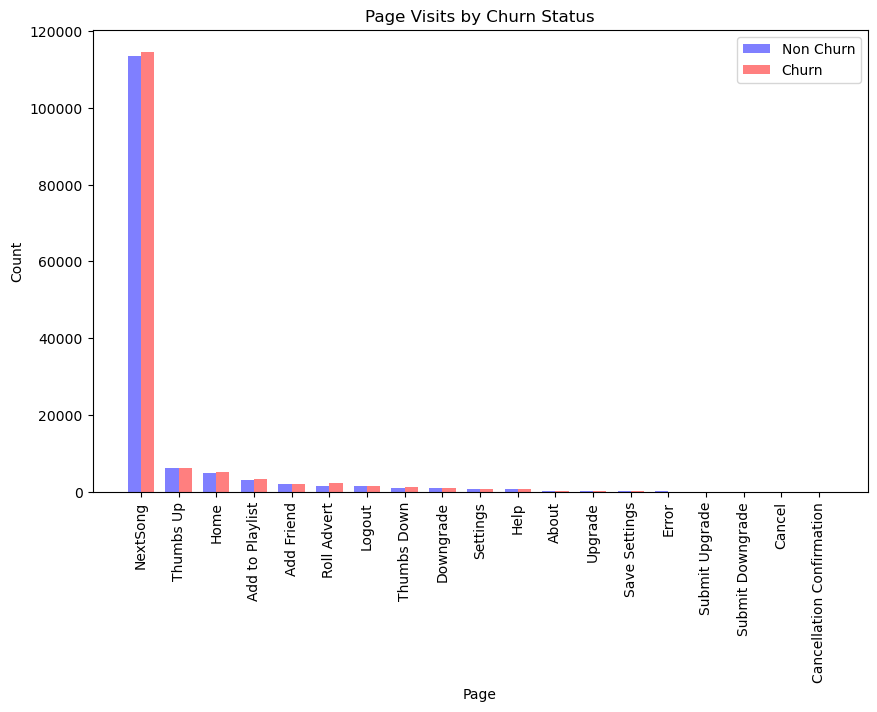

In [18]:
# Set the figure size
# Group by 'page' and 'churn', then count
df_grouped = df.groupby('page', 'churn').count()

df_pages = df_grouped.groupBy('page').pivot('churn').sum('count')
df_pages = df_pages.withColumnRenamed('0', 'non_churn_pages').withColumnRenamed('1', 'churn_pages')
df_pages = df_pages.na.fill(0)
df_pages = df_pages.orderBy(desc('non_churn_pages'), desc('churn_pages'))

pdf_pages = df_pages.toPandas()

plt.figure(figsize=(10, 6))

barWidth = 0.35

r1 = np.arange(len(pdf_pages['page']))
r2 = [x + barWidth for x in r1]

plt.bar(r1, pdf_pages['non_churn_pages'], color='b', width=barWidth, alpha=0.5, label='Non Churn')
plt.bar(r2, pdf_pages['churn_pages'], color='r', width=barWidth, alpha=0.5, label='Churn')

plt.title('Page Visits by Churn Status')
plt.xlabel('Page')
plt.ylabel('Count')
plt.xticks([r + barWidth/2 for r in range(len(pdf_pages['page']))], pdf_pages['page'], rotation=90)

plt.legend()
plt.show()

## Days of Membership

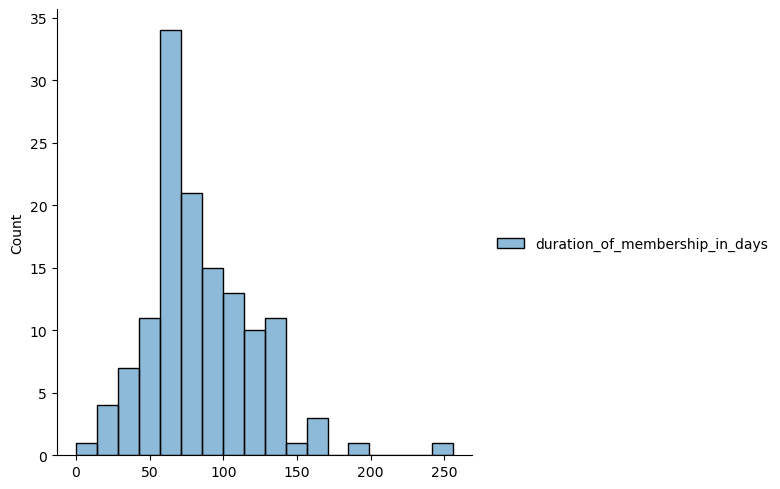

In [19]:
non_churn_membership_in_days = (
    df.filter(col("churn") == 0)
    .groupBy("userId")
    .agg(max("days_of_membership").alias("duration_of_membership_in_days"))
    .distinct()
)

sns.displot(non_churn_membership_in_days.toPandas())

In [20]:
non_churn_membership_in_days.describe().show()

+-------+------------------+------------------------------+
|summary|            userId|duration_of_membership_in_days|
+-------+------------------+------------------------------+
|  count|               133|                           133|
|   mean| 54955.67669172932|             84.33082706766918|
| stddev|108310.27072500312|             35.78592109410069|
|    min|                10|                             0|
|    max|                99|                           256|
+-------+------------------+------------------------------+



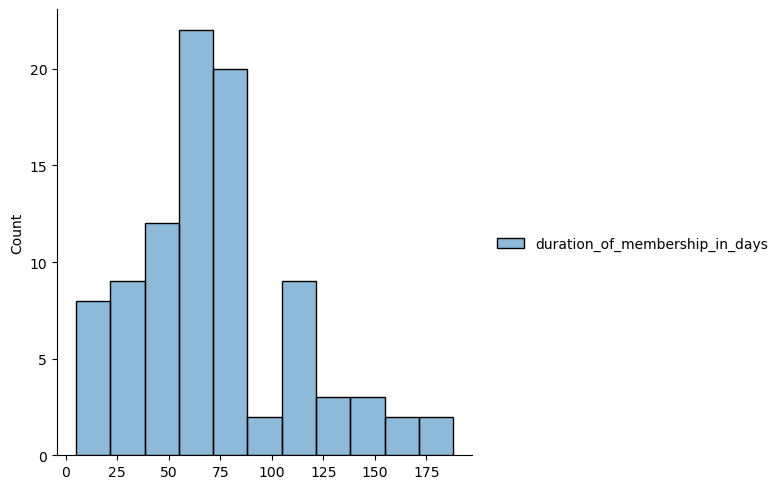

In [21]:
churn_membership_in_days = (
    df
    .filter(col("churn") == 1)
    .groupBy("userId")
    .agg(max("days_of_membership").alias("duration_of_membership_in_days"))
    .distinct()
)

sns.displot(churn_membership_in_days.toPandas())

In [22]:
churn_membership_in_days.describe().show()

+-------+-----------------+------------------------------+
|summary|           userId|duration_of_membership_in_days|
+-------+-----------------+------------------------------+
|  count|               92|                            92|
|   mean|80476.88043478261|             72.18478260869566|
| stddev|99689.49120538104|             39.27948024203082|
|    min|              100|                             5|
|    max|               96|                           188|
+-------+-----------------+------------------------------+



The average membership days are 65% higher for non churn users.

## Item in Session

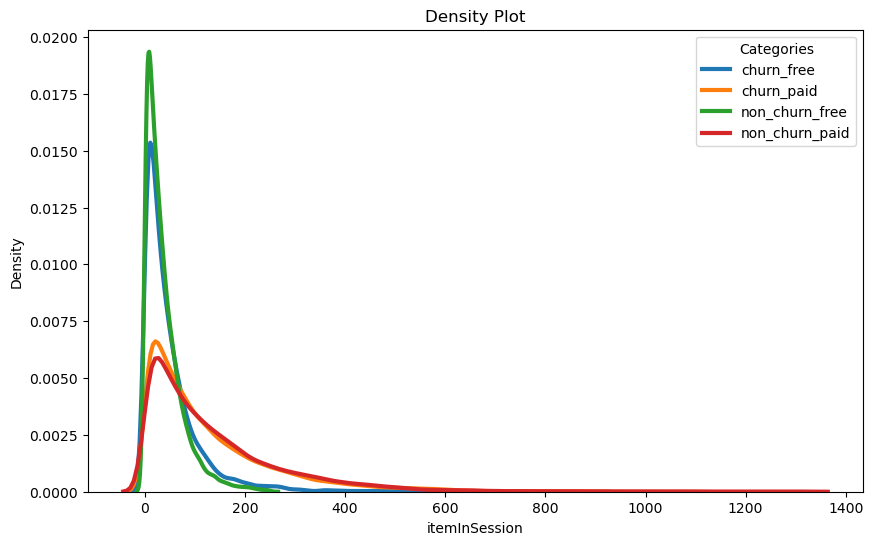

In [98]:
churn_free = df.filter(col("churn") == 1).filter(col("level")== 'free').toPandas()
churn_paid = df.filter(col("churn") == 1).filter(col("level")== 'paid').toPandas()
non_churn_free = df.filter(col("churn") == 0).filter(col("level")== 'free').toPandas()
non_churn_paid = df.filter(col("churn") == 0).filter(col("level")== 'paid').toPandas()

plt.figure(figsize=(10,6))

# Plot each dataframe
sns.kdeplot(data=churn_free['itemInSession'], fill=False, linewidth=3, label='churn_free')
sns.kdeplot(data=churn_paid['itemInSession'], fill=False, linewidth=3, label='churn_paid')
sns.kdeplot(data=non_churn_free['itemInSession'], fill=False, linewidth=3, label='non_churn_free')
sns.kdeplot(data=non_churn_paid['itemInSession'], fill=False, linewidth=3, label='non_churn_paid')

# Add title and labels
plt.title('Density Plot')
plt.xlabel('itemInSession')
plt.ylabel('Density')

# Show the legend and plot
plt.legend(prop={'size': 10}, title = 'Categories')
plt.show()

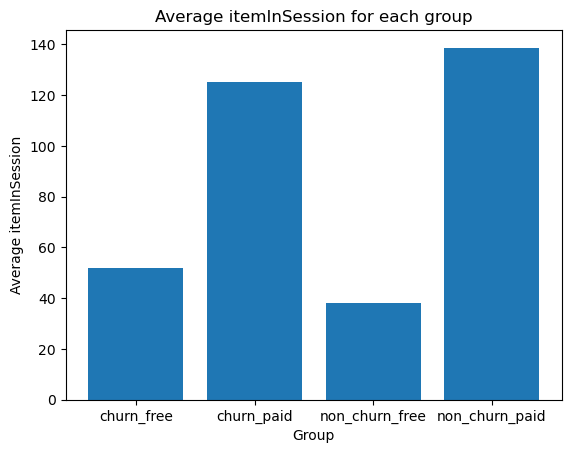

In [112]:
# Calculate the averages
averages = [churn_free['itemInSession'].mean(), churn_paid['itemInSession'].mean(), 
            non_churn_free['itemInSession'].mean(), non_churn_paid['itemInSession'].mean()]

# Define the labels
labels = ['churn_free', 'churn_paid', 'non_churn_free', 'non_churn_paid']

# Create the bar plot
plt.bar(labels, averages)

# Add title and labels
plt.title('Average itemInSession for each group')
plt.xlabel('Group')
plt.ylabel('Average itemInSession')

# Show the plot
plt.show()

### We can see that users who have a paid subscription have more items in sessions, which probably means that they like the app and are heavy users.

In [26]:
non_churn_item_in_session = (
    df.select("itemInSession").filter(col("churn") == 0).toPandas()
)

churn_item_in_session = df.select("itemInSession").filter(col("churn") == 1).toPandas()

In [27]:
non_churn_item_in_session.describe()

,itemInSession
count,137739.000000
mean,121.682044
std,140.411826
min,0.000000
25%,28.500000
50%,75.000000
75%,166.000000
max,1321.000000


In [28]:
churn_item_in_session.describe()

,itemInSession
count,140415.000000
mean,108.245586
std,118.205637
min,0.000000
25%,26.000000
50%,67.000000
75%,148.000000
max,889.000000


### Item in Sessions are pretty similar between churn and non churn users.

## Length

<Axes: >

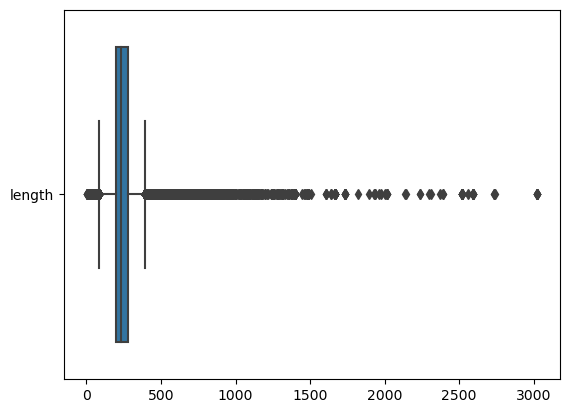

In [29]:
df_length = df.select("length").toPandas().dropna()

sns.boxplot(df_length, orient='h')

In [30]:
df_length.describe()

,length
count,228108.000000
mean,249.117182
std,99.235179
min,0.783220
25%,199.888530
50%,234.500770
75%,277.158730
max,3024.665670


In [31]:
df_length_non_churn = df.select("length").filter(col("churn") == 0).toPandas().dropna()

df_length_churn = df.select("length").filter(col("churn") == 1).toPandas().dropna()

In [32]:
df_length_non_churn.describe()

,length
count,113563.000000
mean,249.132271
std,97.701025
min,0.783220
25%,199.888530
50%,234.631380
75%,277.158730
max,3024.665670


In [33]:
df_length_churn.describe()

,length
count,114545.000000
mean,249.102223
std,100.733543
min,2.167710
25%,199.888530
50%,234.317910
75%,277.158730
max,3024.665670


### The length of the music that churn and non churn users are similar too.

## Gender

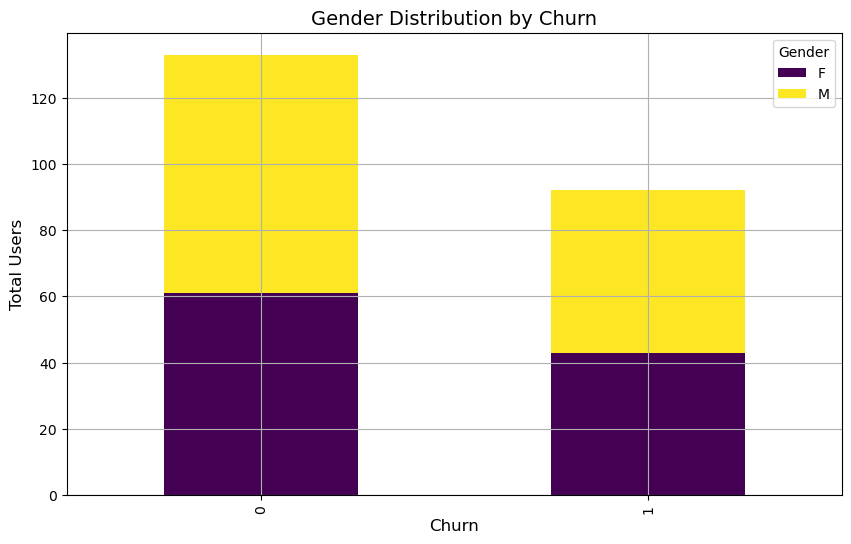

In [120]:
df_pandas_gender = df\
.groupBy("churn", "gender")\
.agg(countDistinct("userId").alias("users_total"))\
.orderBy(["churn", "gender"], ascending=[False, True])\
.toPandas()


df_pandas_gender = df_pandas_gender.pivot(index='churn', columns='gender', values='users_total')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot stacked bar chart
df_pandas_gender.plot(kind='bar', stacked=True, ax=ax, colormap='viridis')

# Add gridlines
ax.grid(True)

# Set labels and title
ax.set_xlabel('Churn', fontsize=12)
ax.set_ylabel('Total Users', fontsize=12)
ax.set_title('Gender Distribution by Churn', fontsize=14)
ax.legend(title='Gender')

plt.show()

## Artist

/home/rafael.silva/anaconda3/envs/sparkify/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 131 (\x83) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


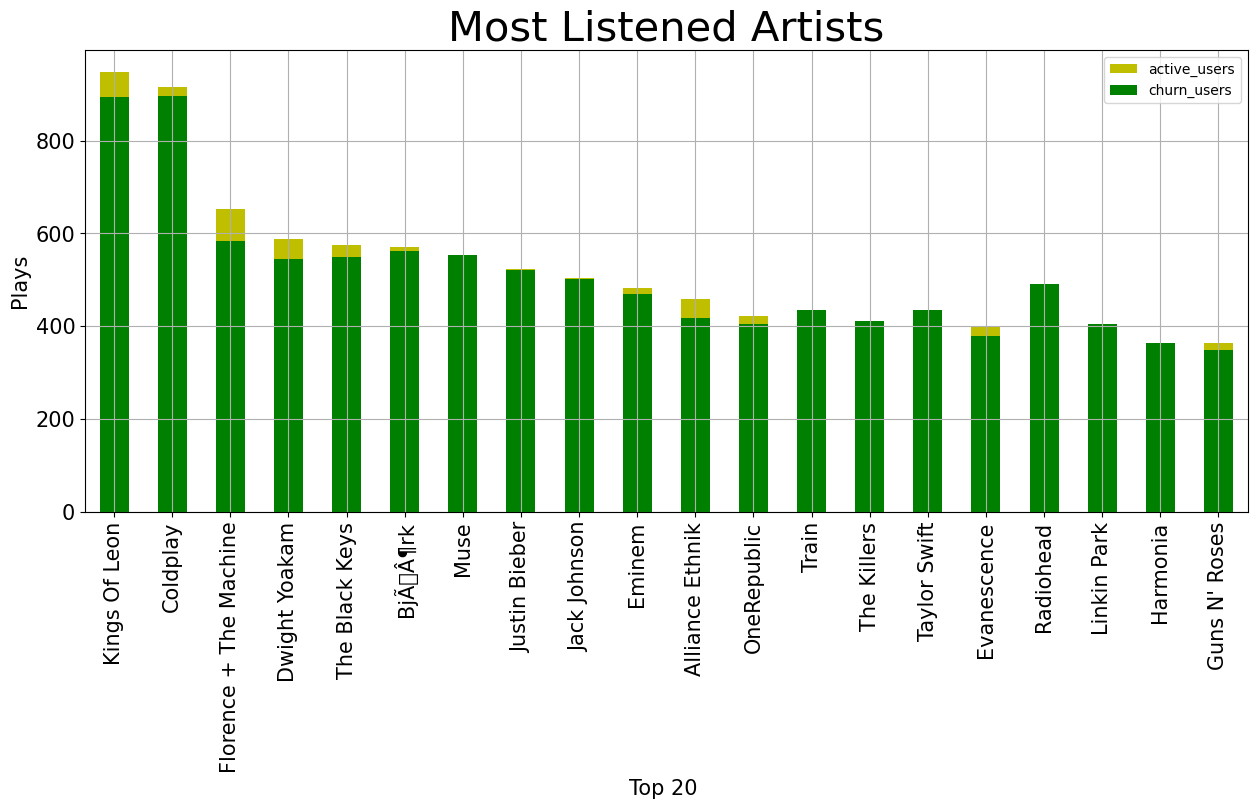

In [35]:
artist_churn = df.filter(col("churn") == 1).groupby('artist').count().toPandas().dropna()
artist_non_churn = df.filter(col("churn") == 0).groupby('artist').count().toPandas().dropna()

artist_churn = artist_churn.rename(columns={"count": "churn_users"})
artist_non_churn= artist_non_churn.rename(columns={"count": "active_users"}) 

artist_churn = artist_churn.set_index('artist')   
artist_non_churn= artist_non_churn.set_index('artist')  

df_artist= pd.concat([artist_churn, artist_non_churn], axis=1, join="outer", sort=True)

df_artist = df_artist.sort_values(by=['active_users', 'churn_users'], ascending=False)

df_artist = df_artist.head(20)
plt.title('Most Listened Artists', fontsize=30)

ax = df_artist['active_users'].plot(kind='bar', figsize=(15, 6), color ='y', legend=True, fontsize=15)
ax = df_artist['churn_users'].plot(kind='bar', legend=True, color='g', fontsize=15) 
ax.set_xlabel("Top 20 ", fontsize=15)
ax.set_ylabel("Plays", fontsize=15)
plt.grid(True)
plt.show()

## Location

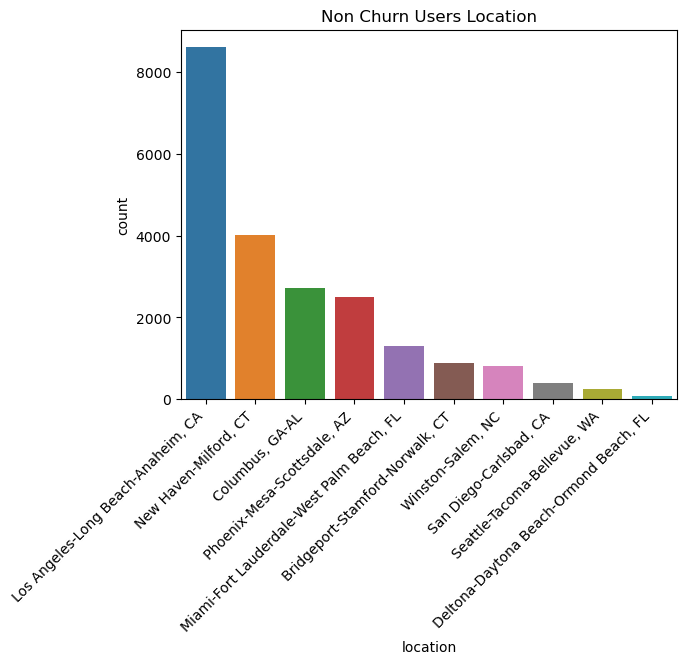

In [128]:
non_churn_location = (
    df
    .filter(col("churn") == 0)
    .groupBy("location")
    .count()
)

non_churn_location = non_churn_location.toPandas().head(10).sort_values(by = "count", ascending = False)

my_plot = sns.barplot(data=non_churn_location, x="location", y="count")
my_plot.set_title("Non Churn Users Location")
_ = my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45,
                        horizontalalignment='right')

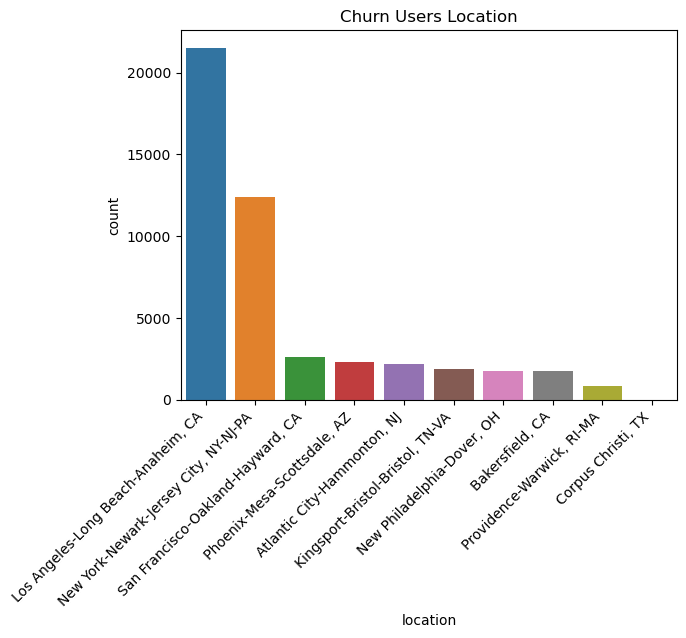

In [130]:
churn_location = (
    df
    .filter(col("churn") == 1)
    .groupBy("location")
    .count()
)

churn_location = churn_location.toPandas().head(10).sort_values(by = "count", ascending = False)

my_plot = sns.barplot(data=churn_location, x="location", y="count")
my_plot.set_title("Churn Users Location")
_ = my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45,
                        horizontalalignment='right')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [172]:
feat_eng = df.groupBy("userId")\
    .agg(
        max("churn").alias("label"),
        count(when(col("page") == 'Error', 1)).alias("error_count"),
        count(when(col("page") == 'Add Friend', 1)).alias("friends_count"),
        count(when(col("page") == 'Roll Advert', 1)).alias("advert_count"),
        count(when(col("page") == 'Add to Playlist', 1)).alias("playlist_count"),
        count(when(col("page") == 'Thumbs Up', 1)).alias("thumbs_up"),
        count(when(col("page") == 'Thumbs Down', 1)).alias("thumbs_down"),
        count(when(col("page") == 'Downgrade', 1)).alias("downgrade"),
        count(when(col("page") == 'Upgrade', 1)).alias("upgrade"),
        count(when(col("page") == 'Submit Upgrade', 1)).alias("submit_upgrade"),
        count(when(col("page") == 'Submit Downgrade', 1)).alias("submit_downgrade"),
        (when(first("level") == 'free', 1).otherwise(0)).alias("first_level_free"),
        (when(first("level") == 'paid', 1).otherwise(0)).alias("fist_level_paid"),
        (when(last("level") == 'free', 1).otherwise(0)).alias("last_level_free"),
        (when(last("level") == 'paid', 1).otherwise(0)).alias("last_level_paid"),
        max("days_of_membership").alias("membership_days"),
        countDistinct("sessionId").alias("session_count")
    ).drop("userId")

In [173]:
feat_eng.filter(col("label") == 1).distinct().show()

+-----+-----------+-------------+------------+--------------+---------+-----------+---------+-------+--------------+----------------+----------------+---------------+---------------+---------------+---------------+-------------+
|label|error_count|friends_count|advert_count|playlist_count|thumbs_up|thumbs_down|downgrade|upgrade|submit_upgrade|submit_downgrade|first_level_free|fist_level_paid|last_level_free|last_level_paid|membership_days|session_count|
+-----+-----------+-------------+------------+--------------+---------+-----------+---------+-------+--------------+----------------+----------------+---------------+---------------+---------------+---------------+-------------+
|    1|          0|           47|          22|            89|      154|         22|       18|      5|             1|               0|               1|              0|              0|              1|             60|           34|
|    1|          2|            7|          30|             7|       11|          5| 

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [175]:
def classification_report(df):
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
    metrics = ["accuracy", "weightedPrecision", "weightedRecall", "f1"]
    for metric in metrics:
        evaluator.setMetricName(metric)
        print(f"{metric}: {evaluator.evaluate(df)}")

In [176]:
training, test = feat_eng.randomSplit([0.8, 0.2], seed=42)

 **VectorAssembler** is a transformer that combines a given list of columns into a single vector column. It is useful for combining raw features and features generated by different feature transformers into a single feature vector, in order to train ML models like logistic regression and decision trees.

In [177]:
feature_columns = feat_eng.columns
feature_columns.remove('label')

assembler = VectorAssembler(inputCols=[*feature_columns], outputCol="input_features")

In [178]:
scaler = Normalizer(inputCol="input_features", outputCol="features")

## Logistic Regression

In [179]:
lr =  LogisticRegression()
pipeline_lr  = Pipeline(stages=[assembler, scaler, lr])

lr_model = pipeline_lr.fit(training)
lr_predictions = lr_model.transform(test)

In [180]:
classification_report(lr_predictions)

accuracy: 0.84


weightedPrecision: 0.8583957219251337
weightedRecall: 0.8400000000000001
f1: 0.8359999999999999


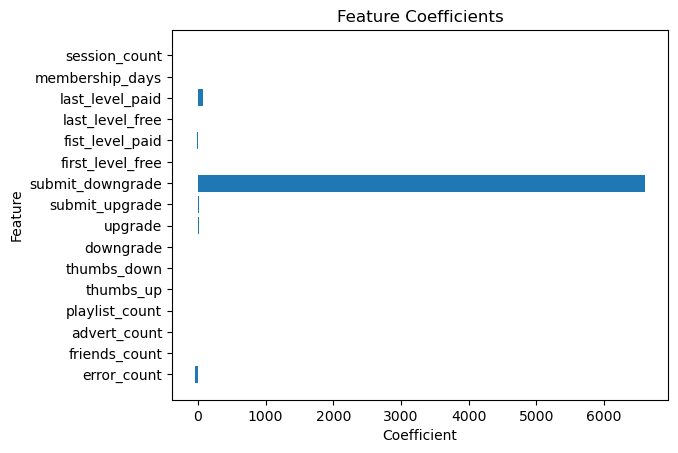

In [181]:
# Get the coefficients
lrModel = lr_model.stages[-1]
coefficients = lrModel.coefficients

# Zip the feature names with their coefficients
featureCoefficients = list(zip(assembler.getInputCols(), coefficients))

featureNames, coefficients = zip(*featureCoefficients)

# Create a bar plot
plt.barh(featureNames, coefficients)
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Feature Coefficients')
plt.show()

We can see that for the Logistic Regression algorithm, the 'submit_downgrade' and 'error' page counts are the most important feature to charactize a churn user.
And for non churn users, the 'last_level_paid' and 'submit upgrade' booleans are the most important.


This suggests that users who frequently visit that submit downgrade or encounter many 'error' pages are more likely to churn.
This implies that users who have recently paid for a level or have submitted an upgrade are less likely to churn.

### Cross Validation

In [182]:
lr_param_grid =ParamGridBuilder()\
.addGrid(lr.regParam, [0.0, 0,1, 0,3])\
.addGrid(lr.maxIter, [10, 50, 100, 1000])\
.build()

lr_cross_val = CrossValidator(estimator=pipeline_lr,
                          estimatorParamMaps=lr_param_grid,
                          evaluator=MulticlassClassificationEvaluator(metricName = "f1"),
                          numFolds=5)  

# Run cross-validation, and choosetg the best set of parameters.
lr_model_cv = lr_cross_val.fit(training)

# Make predictions on test documents. cvModel uses the best model found (lrModel).
lr_model_cv_predictions = lr_model_cv.transform(test)

23/09/17 20:29:27 WARN BlockManager: Asked to remove block broadcast_65626, which does not exist


23/09/17 20:44:26 WARN CacheManager: Asked to cache already cached data.
23/09/17 20:44:26 WARN CacheManager: Asked to cache already cached data.


In [183]:
classification_report(lr_model_cv_predictions)

accuracy: 0.88
weightedPrecision: 0.8886926994906621
weightedRecall: 0.88
f1: 0.878423645320197


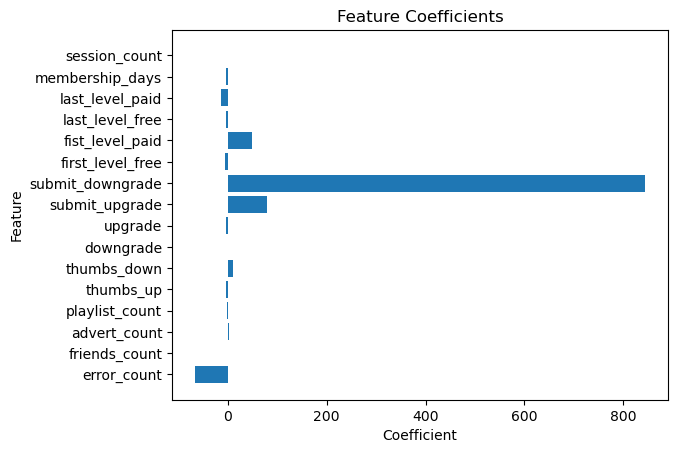

In [185]:
# Get the coefficients
lrModel = lr_model_cv.bestModel.stages[-1]
coefficients = lrModel.coefficients

# Zip the feature names with their coefficients
featureCoefficients = list(zip(assembler.getInputCols(), coefficients))

featureNames, coefficients = zip(*featureCoefficients)

# Create a bar plot
plt.barh(featureNames, coefficients)
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Feature Coefficients')
plt.show()

In [186]:
bestModel = lr_model_cv.bestModel

# Get the last stage of the best model (which is your Logistic Regression model)
lrModel = bestModel.stages[-1]

# Extract the parameters of the best model
paramMap = lrModel.extractParamMap()

# Now you can print or access the parameters
for param, value in paramMap.items():
    print(f"{param.name}: {value}")

aggregationDepth: 2
elasticNetParam: 0.0
family: auto
featuresCol: features
fitIntercept: True
labelCol: label
maxBlockSizeInMB: 0.0
maxIter: 10
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
regParam: 0.0
standardization: True
threshold: 0.5
tol: 1e-06


## Random Forest

In [187]:
rf =  RandomForestClassifier()
pipeline_rf  = Pipeline(stages=[assembler, scaler, rf])

rf_model = pipeline_rf.fit(training)
rf_predictions = rf_model.transform(test)

In [188]:
classification_report(rf_predictions)

accuracy: 0.86
weightedPrecision: 0.864
weightedRecall: 0.86
f1: 0.8588004895960832


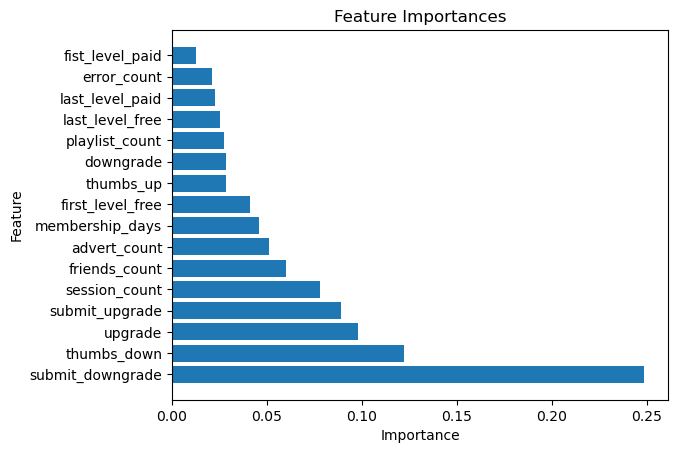

In [189]:
featureNames = assembler.getInputCols()
rfModel = rf_model.stages[-1]

# Zip the feature names with their importance
featureImportances = list(zip(featureNames, rfModel.featureImportances))

# Sort the features based on their importance
featureImportances.sort(key=lambda x: x[1], reverse=True)

# Unzip the feature names and their importance
featureNames, importances = zip(*featureImportances)

# Create a bar plot
plt.barh(featureNames, importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

### Cross Validation

In [190]:
rf_param_grid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [2, 5, 25])
             .addGrid(rf.numTrees, [5, 25, 50])
             .build())

# Create 5-fold CrossValidator
rfcv = CrossValidator(estimator = pipeline_rf,
                      estimatorParamMaps = rf_param_grid,
                      evaluator = MulticlassClassificationEvaluator(metricName = "f1"),
                      numFolds = 5)

# Run cross-validation, and choose the best set of parameters.
rf_model_cv = rfcv.fit(training)
rf_model_cv_predictions = rf_model_cv.transform(test)

In [191]:
classification_report(rf_model_cv_predictions)

accuracy: 0.84
weightedPrecision: 0.8411822660098522
weightedRecall: 0.84
f1: 0.8392207792207793


## GBTClassifier

In [192]:
gbt =  GBTClassifier()
pipeline_gbt  = Pipeline(stages=[assembler, scaler, gbt])

gbt_model = pipeline_gbt.fit(training)
gbt_predictions = gbt_model.transform(test)

In [193]:
classification_report(gbt_predictions)

accuracy: 0.72
weightedPrecision: 0.72
weightedRecall: 0.72
f1: 0.72


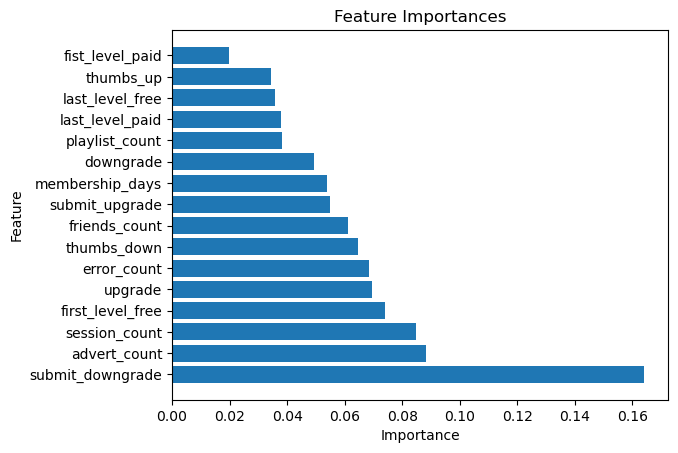

In [194]:
featureNames = assembler.getInputCols()
gbtModel = gbt_model.stages[-1]

# Zip the feature names with their importance
featureImportances = list(zip(featureNames, gbtModel.featureImportances))

# Sort the features based on their importance
featureImportances.sort(key=lambda x: x[1], reverse=True)

# Unzip the feature names and their importance
featureNames, importances = zip(*featureImportances)

# Create a bar plot
plt.barh(featureNames, importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

### Cross Validation

In [195]:
gbt_param_grid = (
    ParamGridBuilder()
    .addGrid(gbt.maxDepth, [2, 4, 6])
    .addGrid(gbt.maxIter, [10, 20])
    .addGrid(gbt.stepSize, [0.1, 0.01])
    .build()
)

# Create 5-fold CrossValidator
gbtcv = CrossValidator(
    estimator=pipeline_gbt,
    estimatorParamMaps=gbt_param_grid,
    evaluator=MulticlassClassificationEvaluator(metricName="f1"),
    numFolds=5,
)

# Run cross-validation, and choose the best set of parameters.
gbt_model_cv = gbtcv.fit(training)
gbt_model_cv_predictions = gbt_model_cv.transform(test)

In [196]:
classification_report(gbt_model_cv_predictions)

accuracy: 0.72
weightedPrecision: 0.72
weightedRecall: 0.72
f1: 0.72


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

## Conclusions

In the course of this project, we evaluated three distinct algorithms: Logistic Regression, Random Forest, and Gradient-Boosted Trees (GBTs).
Upon initial testing with default parameters, we observed that the GBTs did not yield satisfactory results. In contrast, both Logistic Regression and Random Forest demonstrated superior performance in predicting user churn.
Subsequently, we employed Cross Validation and feature tuning in an attempt to enhance our prediction accuracy:
TunningUpon examining the feature coefficients in the Logistic Regression model, we discovered that the 'Submit Downgrade' feature was significantly more important than the others. This indicates that the algorithm has identified this feature as the most critical in predicting whether a user will churn. Similarly, in the Random Forest model, the 'Submit Downgrade' feature emerged as the most important.